# Projet Python: Donnée RH, pourquoi les employés quittent l'entreprise:

<p style="text-align:right";>*Fait par **Jean-Christophe CARLES** - 2A ENSAE 2016-2017*</p> 

In [78]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [77]:
from IPython.core.display import HTML
HTML(""" 
<style> 
.text_cell_render {
font-family: Verdana, serif;
text-align: justify; 
}

div.text_cell_render h1 { /* Main titles bigger, centered */
font-size: 2.2em;
line-height:1.4em;
text-align:center;
}

div.text_cell_render h2 { /* Main titles bigger, centered */
font-size: 1.9em;
line-height:1 em;
text-align:center;
}

div.cell { /* Tunes the space between cells */
margin-top:1em;
margin-bottom:1em;
}
</style>

""")

## Introduction
-----

<p style="text-align:justify";>J'ai choisi un jeu de donné RH de 10 variables sur presque 15 000 individus. Les variables donnent différentes informations sur les employés comme la tranche de salaire ou le nombre de projets réalisés par exemple. Une variable donne une information si les individus ont quittés l'entreprise ou non. 
<p>&nbsp; </p>
Je vais donc essayer de dégager un profil pour les employés quittant l'entreprise, voir quels facteurs les poussent à partir dans un premier temps. Dans un second temps je vais essayer de prédire en choisissant le meilleur modèle possible quels employés risquent de quitter l'entreprise dans le futur. </p>

---

Note: Exécuter les cellules dans l'ordre(surtout celle qui modifient le data frame) il peut y avoir des dépendances inattendues...

In [2]:
# packages
import pandas as pd
import numpy as np
import matplotlib
from sklearn import svm, linear_model, datasets, metrics
import matplotlib.pyplot as plt
import seaborn as sns

import plotly
import plotly.graph_objs as go
from plotly.graph_objs import Scatter, Layout
import plotly.tools as tls
import plotly.plotly as py

plotly.offline.init_notebook_mode() # run at the start of every notebook
%matplotlib inline
matplotlib.style.use('ggplot')

Telechargement et visualisation des données

In [3]:
#dataset

data=pd.read_csv("C:/python//HR_comma_sep.csv", header=0, na_values="NA", sep=',')

print(data.shape, data.columns)
data.head()

(14999, 10) Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'sales', 'salary'],
      dtype='object')


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


## Description du jeu de données
----

On remarque que la colonne 'sales' contient les départements de travail, on la renomme 'dept'

In [4]:
data.columns = ['satisfaction_level','last_evaluation','number_project','average_montly_hours','time_spend_company','Work_accident','left','promotion_last_5years','dept','salary']
data.describe().T

,count,mean,std,min,25%,50%,75%,max
satisfaction_level,14999.0,0.612834,0.248631,0.09,0.44,0.64,0.82,1.0
last_evaluation,14999.0,0.716102,0.171169,0.36,0.56,0.72,0.87,1.0
number_project,14999.0,3.803054,1.232592,2.00,3.00,4.00,5.00,7.0
average_montly_hours,14999.0,201.050337,49.943099,96.00,156.00,200.00,245.00,310.0
time_spend_company,14999.0,3.498233,1.460136,2.00,3.00,3.00,4.00,10.0
Work_accident,14999.0,0.144610,0.351719,0.00,0.00,0.00,0.00,1.0
left,14999.0,0.238083,0.425924,0.00,0.00,0.00,0.00,1.0
promotion_last_5years,14999.0,0.021268,0.144281,0.00,0.00,0.00,0.00,1.0


On a une première visualisation des données, on regarde les différentes modalitées de toutes les variables pour comprendre mieux.

In [5]:
for var in data.columns:
    print('{0}: \n{1}\n '.format(var,pd.Series(data[var]).unique().tolist()))

satisfaction_level: 
[0.38, 0.8, 0.11, 0.72, 0.37, 0.41, 0.1, 0.92, 0.89, 0.42, 0.45, 0.84, 0.36, 0.78, 0.76, 0.09, 0.46, 0.4, 0.82, 0.87, 0.57, 0.43, 0.13, 0.44, 0.39, 0.85, 0.81, 0.9, 0.74, 0.79, 0.17, 0.24, 0.91, 0.71, 0.86, 0.14, 0.75, 0.7, 0.31, 0.73, 0.83, 0.32, 0.54, 0.27, 0.77, 0.88, 0.48, 0.19, 0.6, 0.12, 0.61, 0.33, 0.56, 0.47, 0.28, 0.55, 0.53, 0.59, 0.66, 0.25, 0.34, 0.58, 0.51, 0.35, 0.64, 0.5, 0.23, 0.15, 0.49, 0.3, 0.63, 0.21, 0.62, 0.29, 0.2, 0.16, 0.65, 0.68, 0.67, 0.22, 0.26, 0.99, 0.98, 1.0, 0.52, 0.93, 0.97, 0.69, 0.94, 0.96, 0.18, 0.95]
 
last_evaluation: 
[0.53, 0.86, 0.88, 0.87, 0.52, 0.5, 0.77, 0.85, 1.0, 0.54, 0.81, 0.92, 0.55, 0.56, 0.47, 0.99, 0.51, 0.89, 0.83, 0.95, 0.57, 0.49, 0.46, 0.62, 0.94, 0.48, 0.8, 0.74, 0.7, 0.78, 0.91, 0.93, 0.98, 0.97, 0.79, 0.59, 0.84, 0.45, 0.96, 0.68, 0.82, 0.9, 0.71, 0.6, 0.65, 0.58, 0.72, 0.67, 0.75, 0.73, 0.63, 0.61, 0.76, 0.66, 0.69, 0.37, 0.64, 0.39, 0.41, 0.43, 0.44, 0.36, 0.38, 0.4, 0.42]
 
number_project: 
[2, 5, 7, 6, 

On confirme le fait que 'dept' contient les informations sur les départements de travail des employés.
On remarque aussi que la variable 'salary' contient trois niveau.

On remarque aussi que les variables 'promotion_last_5years', 'left' et 'Work_accident' sont binaires.

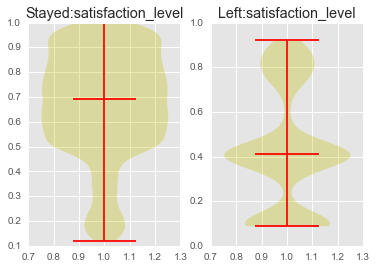

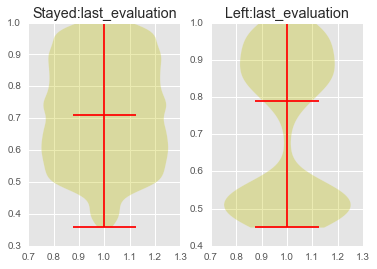

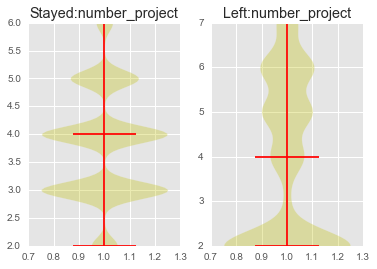

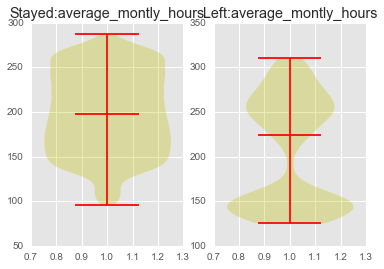

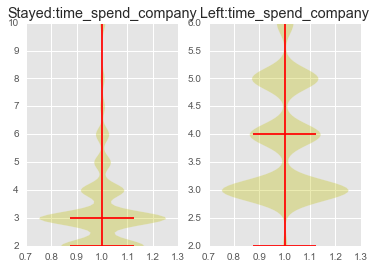

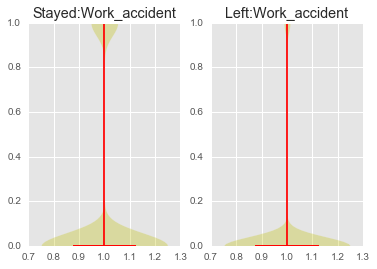

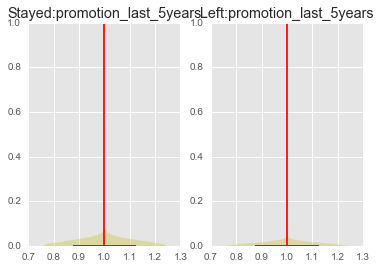

In [6]:
# On trace quelque graphes pour explorer les données

#Fonction qui trace la répartition d'une variable selon les niveau de 'left' (partie ou encore présente)
def plotv(data, what):
    f, ax = plt.subplots(nrows=1, ncols=2)
    stayed = data[data.left==0][what]
    left = data[data.left == 1][what]
    ax[0].violinplot(stayed.values.tolist(), showmeans=False, showmedians=True)
    ax[0].set_title('Stayed:' + what)
    ax[1].violinplot(left.values.tolist(), showmeans=False, showmedians=True)
    ax[1].set_title('Left:' + what)
    plt.show()

def plotVals():
    #Trace toutes les colonnes de type numérique selon les niveaux de 'left'
    for colname in data.columns:
        if colname not in ['left', 'dept', 'salary']:
            plotv(data, colname)

plotVals()

<p style="text-align:justify";>Pour le niveau de satisfaction on remarque qu'il est moins dense au niveau des valeurs les plus basses et semble être à peu près bien réparti autour de la valeur 0,4 et au dessus.
<p>&nbsp; </p>
Au niveau de la valeur 0,4 on remarque que la variable 'level' semble influencer la variable 'leaving'. Contre intuitivement, les valeurs de satisfaction au dessus de 0,7 semblent aussi avoir un effet sur leaving.
Il se pourrait que cela reflète le fait qu'ils recherchent de plus grand défis.
<p>&nbsp; </p>
Pour la variable qui indique le niveau de la dernière évaluation le graphique semble similaire à celui du niveau de satisfaction à part pour les valeurs plus basses.
<p>&nbsp; </p>
La variable qui indique le nombre de projets réalisés, la variable 'leaving' est plus dense au niveau des valeurs plutôt basses (2) ce niveau de projets est le minimum.
<p>&nbsp; </p>
Le nombre d'heure moyen par mois les valeurs entre 170 et 210 semble ne partir alors que les valeurs hors de cette fourchette semblent quitter l'entreprise.
<p>&nbsp; </p>
On remarque que les employés ayant plus de 6 ans d'ancienneté ne partent pas  et les gens restent en moyenne au moins 2 ans et demi.
<p>&nbsp; </p>
Les variables donnant des informations sur les acidents du travail et la promotion au cours de 5 dernières années n'apportent que très peu d'information supplémentaires.</p>


             left
salary left      
high   0     1155
       1       82
low    0     5144
       1     2172
medium 0     5129
       1     1317


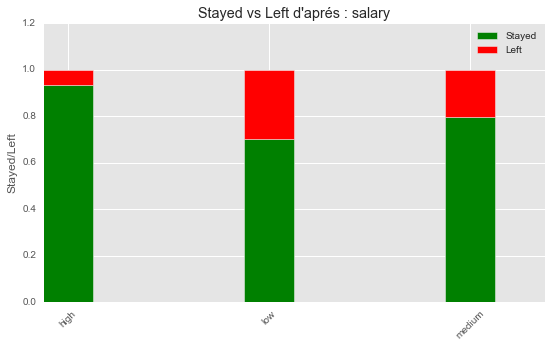

                  left
dept        left      
IT          0      954
            1      273
RandD       0      666
            1      121
accounting  0      563
            1      204
hr          0      524
            1      215
management  0      539
            1       91
marketing   0      655
            1      203
product_mng 0      704
            1      198
sales       0     3126
            1     1014
support     0     1674
            1      555
technical   0     2023
            1      697


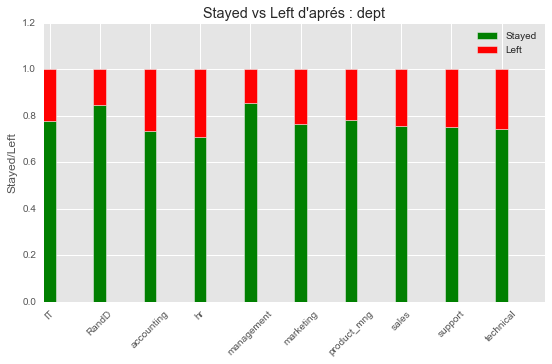

In [11]:
#Etudions les variables salaires et départements:

def plot_stacked(colname):
    dfg = data.groupby([colname, 'left']).agg({'left':'count'})
    print(dfg)
    vals = [i[0] for i in dfg.values]
    stayed = vals[::2]
    left = vals[1::2]
    
    # On calcule les valeurs en pourcentage afin d'avoir une meilleure observation
    stayedp = []
    leftp = []
    for i in range(len(stayed)):
        total = stayed[i]+left[i]
        stayedp.append(float(stayed[i]/total))
        leftp.append(float(left[i]/total))
        
    levels = dfg.index.levels[0].tolist()
    N = len(levels)
    ind = np.arange(N)
    width = 0.25
    p1 = plt.bar(ind, stayedp, width, color = 'g')
    p2 = plt.bar(ind, leftp, width, color = 'r', bottom=stayedp)
    plt.ylabel('Stayed/Left')
    plt.ylim([0,1.2])
    plt.title('''Stayed vs Left d'aprés : ''' + colname)
    plt.xticks(ind + width/2., levels, rotation=45)
    plt.legend((p1[0], p2[0]), ('Stayed', 'Left'))
    fig = plt.gcf()
    fig.set_size_inches(9, 5, forward=True)
    plt.show()

plot_stacked('salary')
plot_stacked('dept')

Pour la variable indiquant le salaire on remarque que très peu de personne gagnant un salaire haut sont parties. Et plus de personnes ayant un salaire bas sont parties que de personnes ayant un salaire moyen.

Au niveau des départements, les départements Management et R&D semble moins partir alors RH et comptables sembles plus partir. Les autres départements semblent avoir des comportements similaires.


On dessine quelques tableaux croisées dynamiques afin d'avoir plus d'information ou de confirmer les conclusion de ci-dessus.

In [12]:
df_jobtype = pd.pivot_table(data,
                        values = ['satisfaction_level', 'last_evaluation'],
                        index = ['dept'],
                        columns = [],aggfunc=[np.mean], 
                        margins=True).fillna('')

cm = sns.light_palette("green", as_cmap=True)
df_jobtype.style.background_gradient(cmap=cm)

In [58]:
df_jobtype_salary = pd.pivot_table(data,
                        values = ['satisfaction_level', 'last_evaluation'],
                        index = ['dept', 'salary'],
                        columns = [],aggfunc=[np.mean], 
                        margins=True).fillna('')
cm = sns.light_palette("green", as_cmap=True)
df_jobtype_salary.style.background_gradient(cmap=cm)

In [14]:
df_jobtype_salary_prom = pd.pivot_table(data,
                        values = ['satisfaction_level', 'last_evaluation'],
                        index = ['dept','promotion_last_5years', 'salary'],
                        columns = [],aggfunc=[np.mean], 
                        margins=True).fillna('')

cm = sns.light_palette("green", as_cmap=True)
df_jobtype_salary_prom.style.background_gradient(cmap=cm)

c:\users\utilisateur\anaconda3\lib\site-packages\pandas\formats\style.py:251: PerformanceWarning: indexing past lexsort depth may impact performance.
  value = self.data.iloc[r, c]


<p style="text-align:justify";>Ces tableaux sont assez dur à interpréter on peux cependant supposer une forte corrélation positive entre 'last_evaluation' et 'satisfaction_level'. Ce qui paraît assez logique puisque appart un évènement exceptionel l'avis d'un employé sur l'entreprise ne change pas trop.</p>

In [15]:
df_jobtype_prom = pd.pivot_table(data,
                        values = ['satisfaction_level', 'last_evaluation'],
                        index = ['dept','promotion_last_5years'],
                        columns = [],aggfunc=[np.mean], 
                        margins=True).fillna('')

cm = sns.light_palette("green", as_cmap=True)
df_jobtype_prom.style.background_gradient(cmap=cm)

In [16]:
df_jobtype_salary_time = pd.pivot_table(data,
                        values = ['satisfaction_level', 'last_evaluation'],
                        index = ['time_spend_company', 'salary'],
                        columns = [],aggfunc=[np.mean], 
                        margins=True).fillna('')
cm = sns.light_palette("green", as_cmap=True)
df_jobtype_salary_time.style.background_gradient(cmap=cm)

La plupart des niveaux de satisfactions ont cependant diminués depuis la dernière évaluation.

On trace finalement quelques boîtes à moustache pour terminer l'exploration des données notemment en fonction des départements.

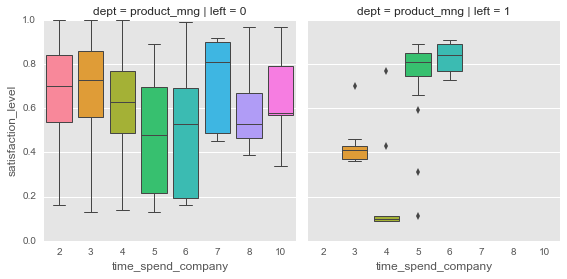

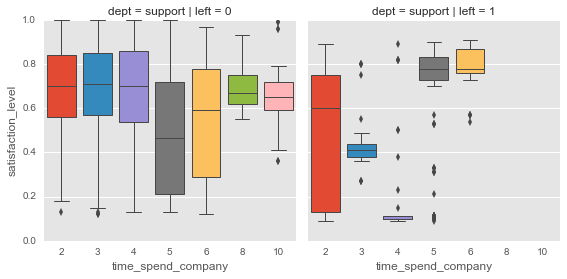

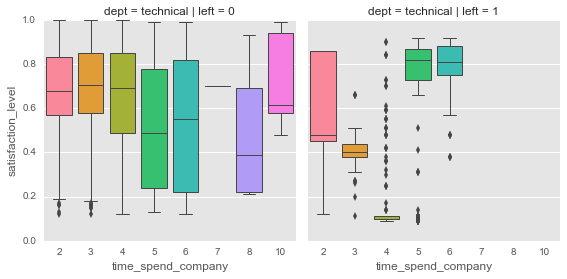

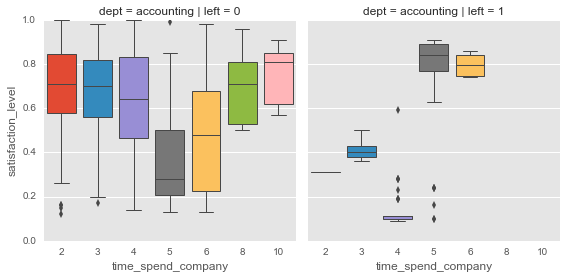

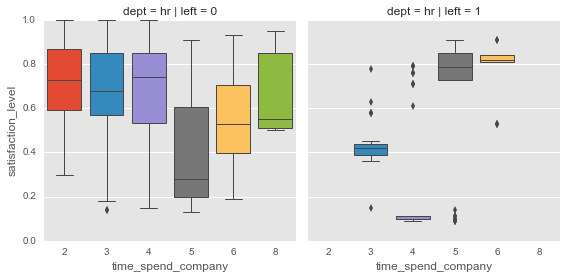

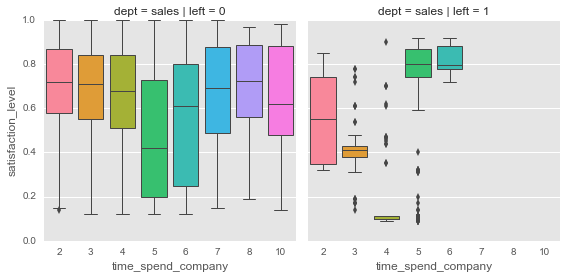

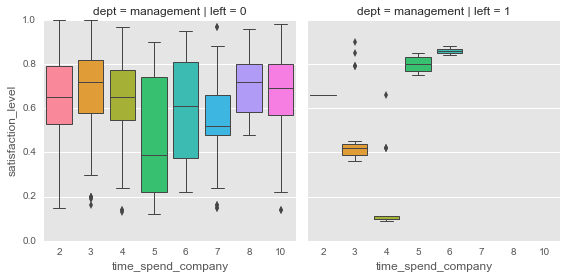

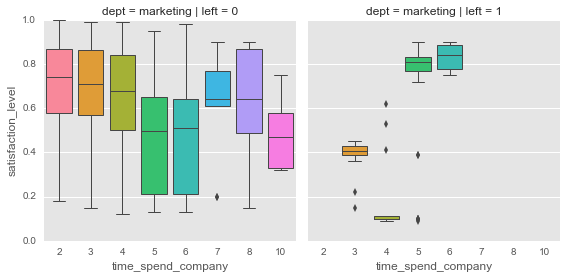

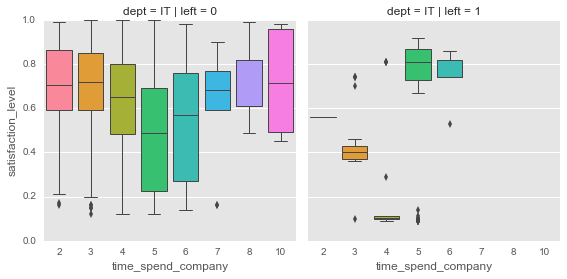

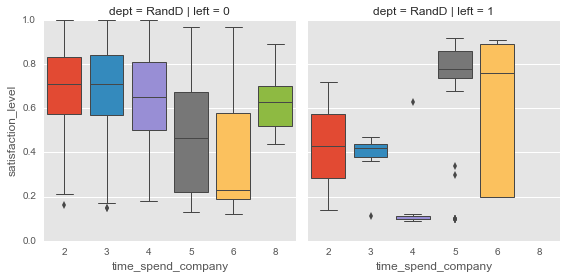

In [17]:
for i in set(data['dept']):
    aa= data[data['dept'].isin([i])]
    g = sns.factorplot(x='time_spend_company', y="satisfaction_level",data=aa, 
                   saturation=1, kind="box", col = 'left', row = 'dept',
                   ci=None, aspect=1, linewidth=1)

<p style="text-align:justify";>On remarque que parmis les individus qui sont partis la plupart de ceux qui passaient le plus de temps à la compagnie avaient un niveau de satisfaction très haut mais sont partis quand même. On peut supposer que c'étaient des employés très compétants qui ont pu être recruté ailleur. 
Alors que ceux qui passaient un temps moyen au sein de la compagnie évaluaient leur satisfaction assez basse ce qui a du les pousser à partir.
Et finalement ceux qui passent le plus de temps ne sont pas partis.</p>

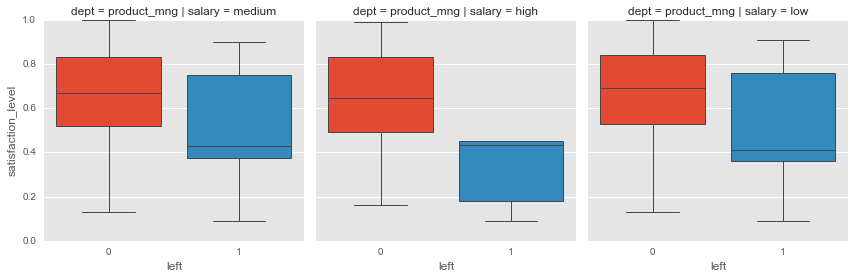

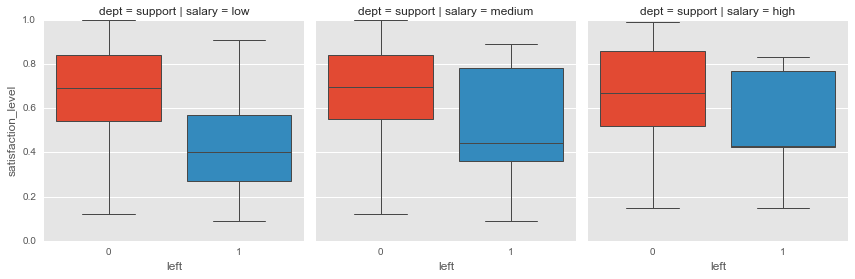

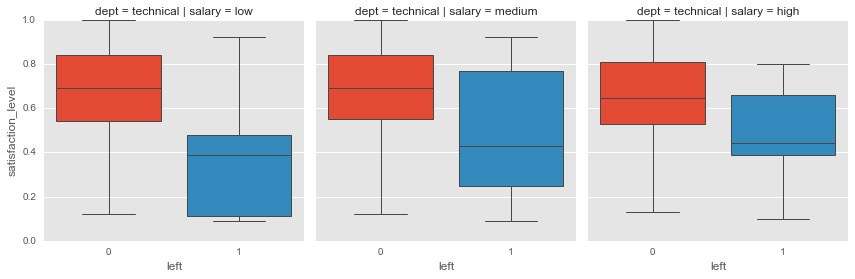

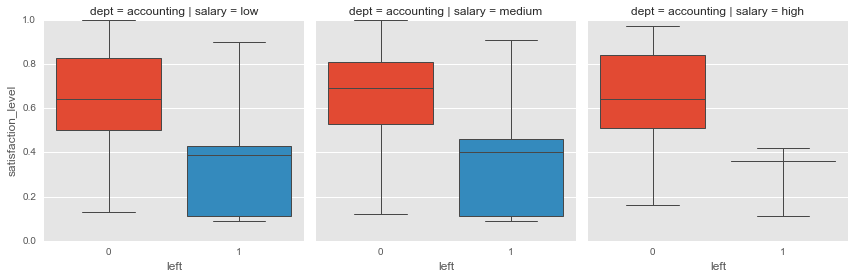

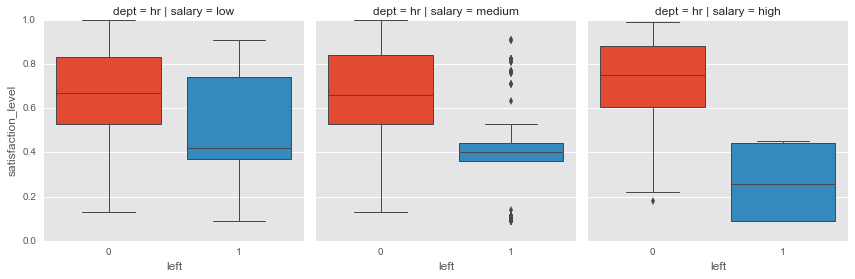

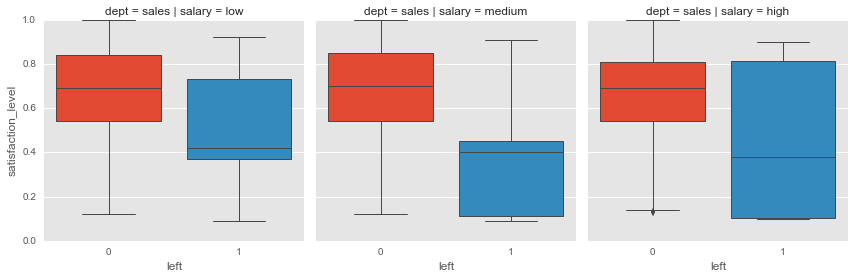

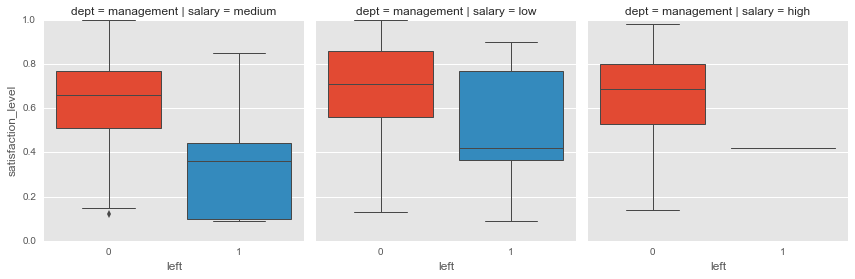

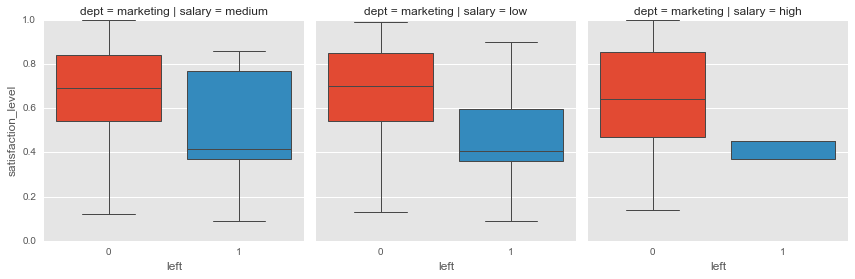

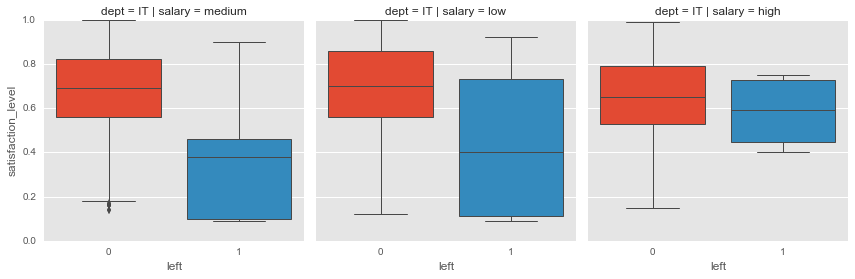

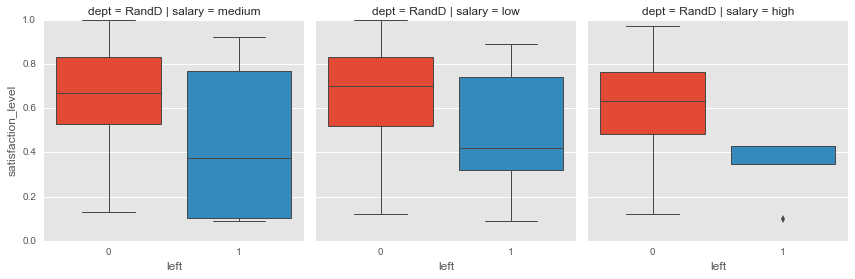

In [18]:
for i in set(data['dept']):
    aa= data[data['dept'].isin([i])]
    g = sns.factorplot(x='left', y="satisfaction_level",data=aa, 
                   saturation=1, kind="box", col = 'salary',row='dept', 
                   ci=None, aspect=1, linewidth=1)

<p style="text-align:justify";>Pour la plupart des départements, les niveaux de satisfactions entre ceux qui sont partis et ceux qui restent ont des moyennes significativement differentes, notemment pour les salaires bas et moyen. Le critère de satisfaction est donc déterminent de la variable 'left'. On trace finalement la matrice des corrélations.</p>

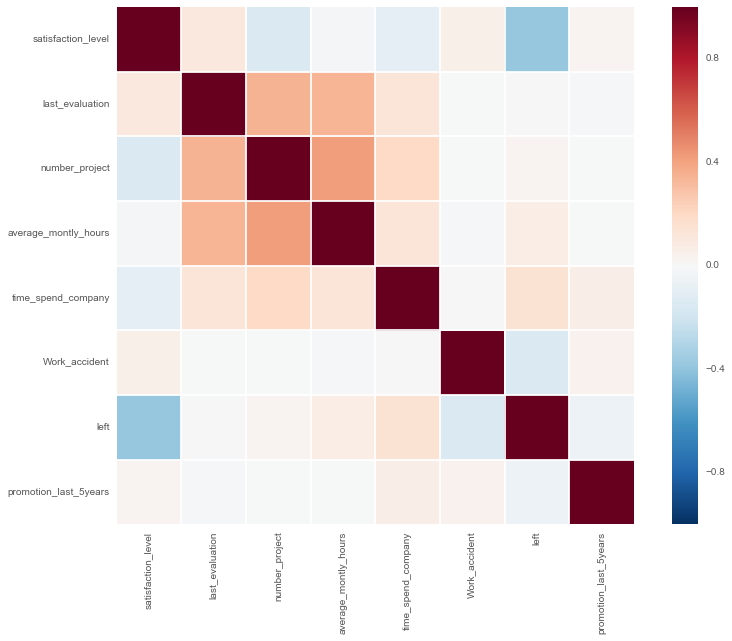

In [19]:
#On calcule la matrice de corrélation
corrmat = data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corrmat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=1, square=True)

# Use matplotlib directly to emphasize known networks
networks = corrmat.columns

for i, network in enumerate(networks):
    if i and network != networks[i - 1]:
        ax.axhline(len(networks) - i, c="w")
        ax.axvline(i, c="w")
f.tight_layout()

On remarque une très grande correlation entre le nombre de projets et le nombre moyen d'heure mensuel. On va donc regarder le nombre de projets en fonction des salaires et de leurs départements.

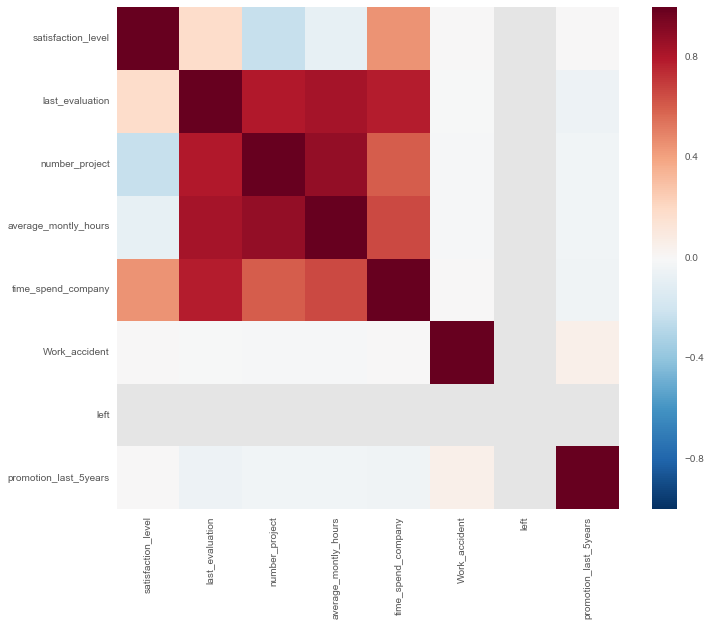

In [20]:
#d'abord on regarde la matrice des corrélations pour les individus ayant quitté l'entreprise
figsize=(9,9)
plt.subplots(figsize=(12, 9))
data_left = data[data['left']==1]
reduced_variable_correlations = data_left.corr()
reduced_variable_correlations
sns.heatmap(reduced_variable_correlations, vmax=1, square=True)

On retrouve les mêmes corrélations encore plus fortes. 'Last_evaluation' semble corrélé avec le travail fourni au sein de l'entreprise alors que le niveau de satisfaction lui semble être anti-corrélé.

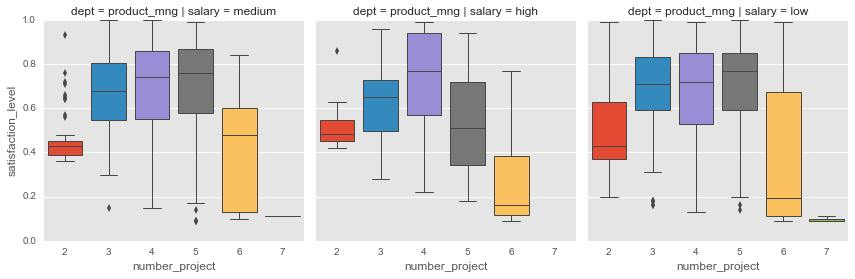

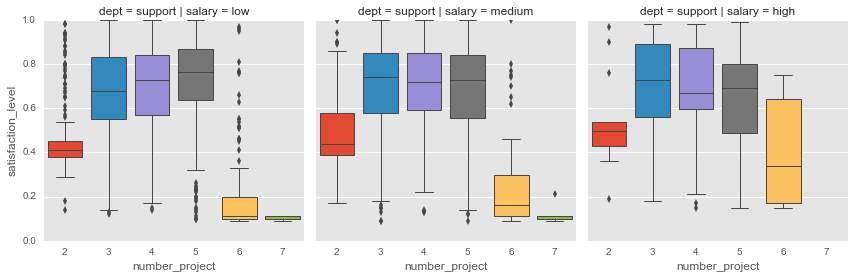

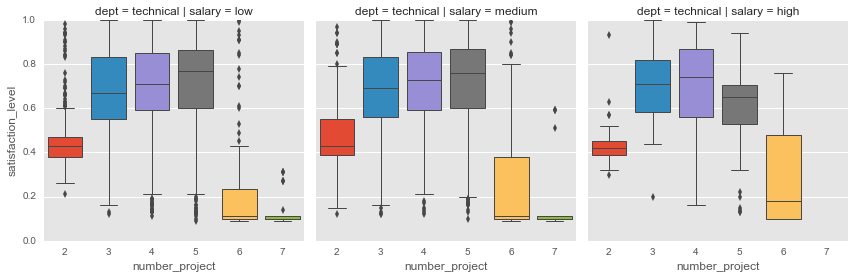

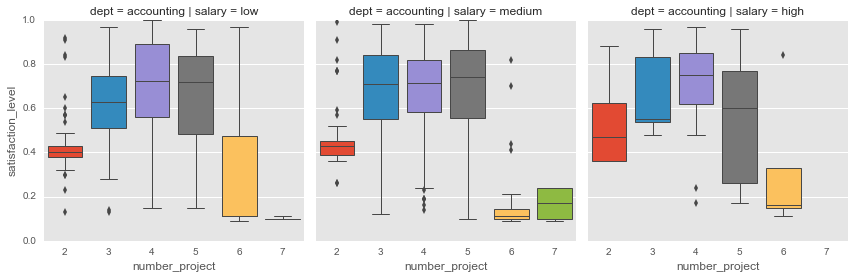

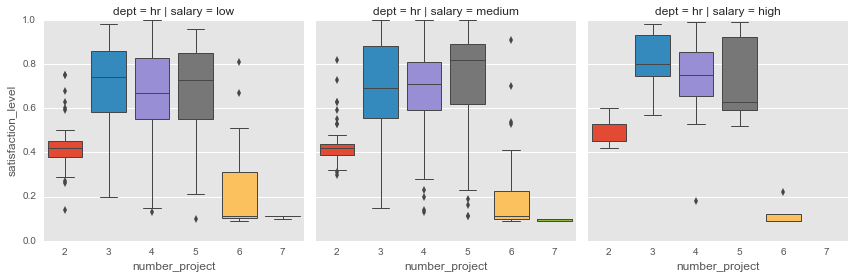

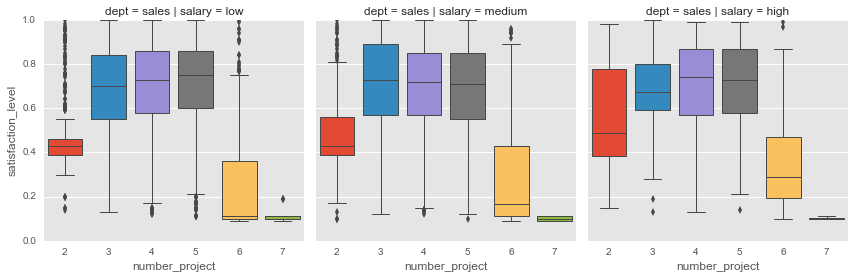

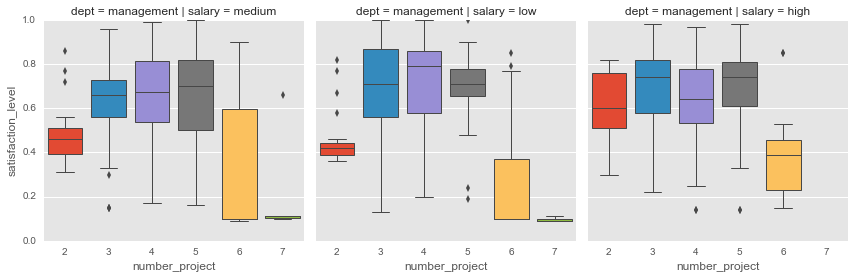

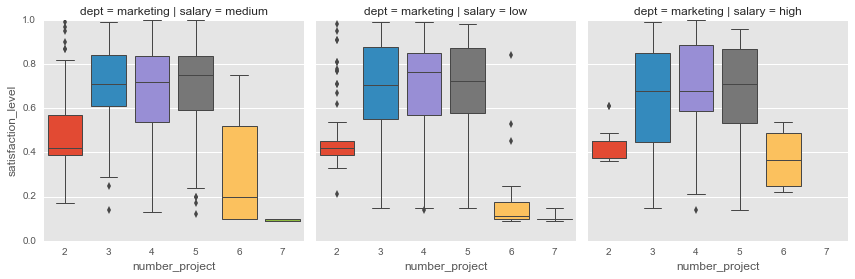

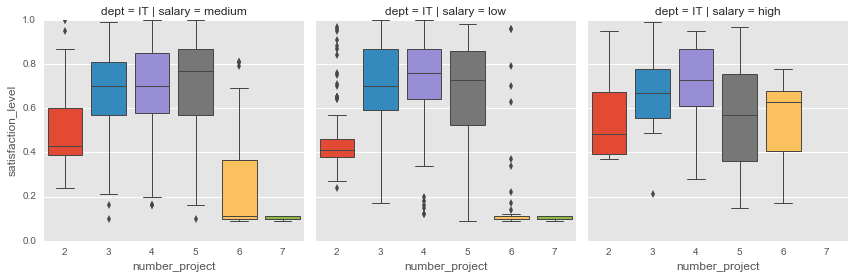

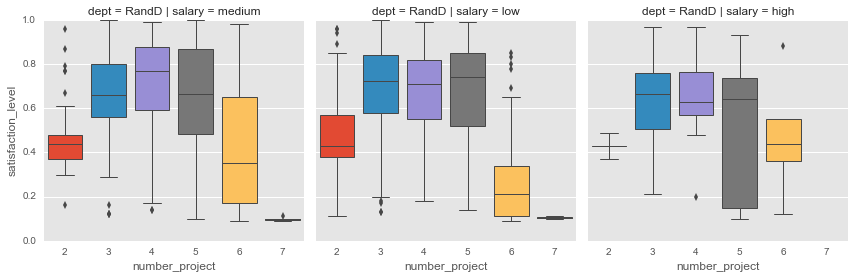

In [21]:
for i in set(data['dept']):
    aa= data[data['dept'].isin([i])]
    g = sns.factorplot(x='number_project', y="satisfaction_level",data=aa, 
                   saturation=1, kind="box", col = 'salary', row='dept', 
                   ci=None, aspect=1, linewidth=1) 

On comprends alors que la valeur idéale pour le nombre de projets est entre 3 et 5. Si les employés font que peu de projets ils ne sont pas satisfait, et s'ils en font trop  ils ne sont pas satisfaits non plus. Travailler beaucoup semble réduire la satisfaction significativement.

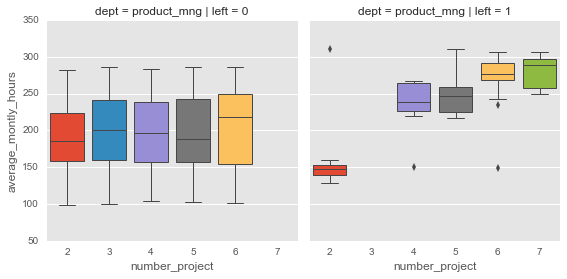

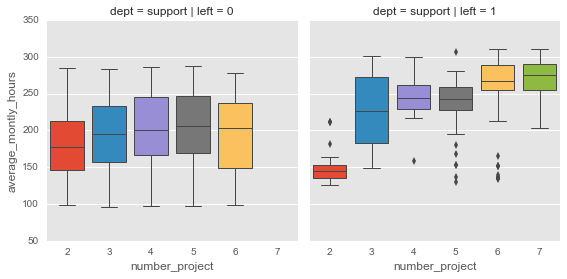

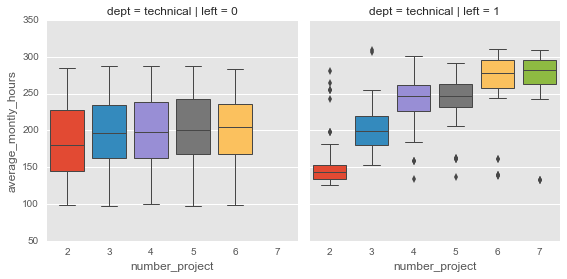

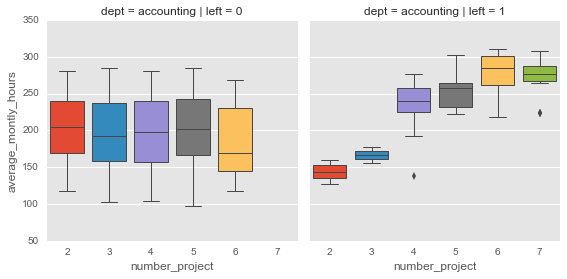

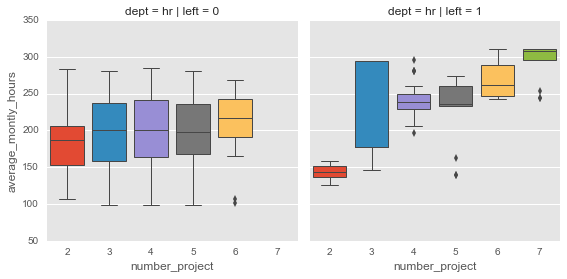

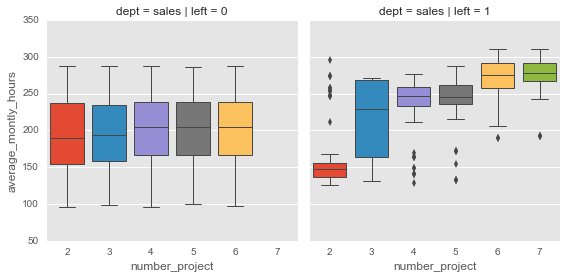

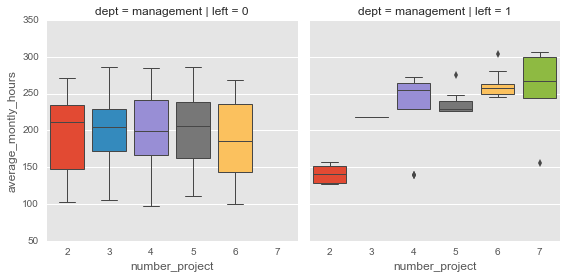

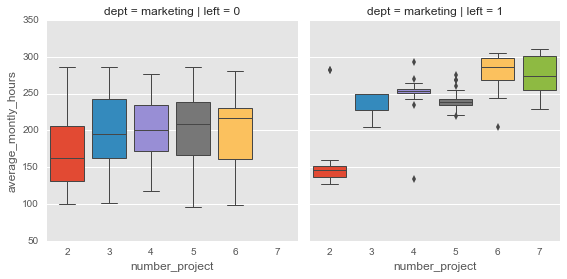

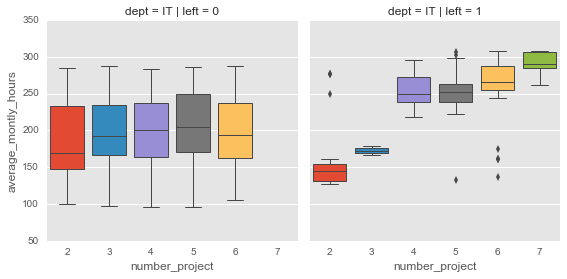

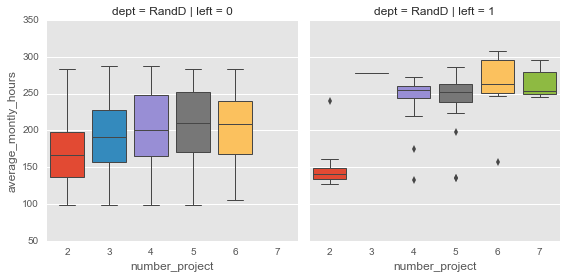

In [22]:
for i in set(data['dept']):
    aa= data[data['dept'].isin([i])]
    g = sns.factorplot(x='number_project', y="average_montly_hours",data=aa, 
                   saturation=1, kind="box", col = 'left', row='dept', 
                   ci=None, aspect=1, linewidth=1)

Il semble que le nombre d'heure mensuelles moyen est un facteur significatif. Ainsi, les employés qui sont partis travaillaient en moyenne plus d'heure que ceux qui sont restés.

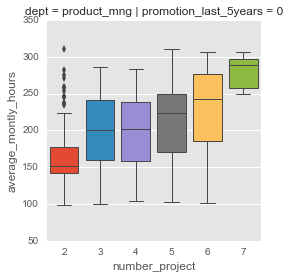

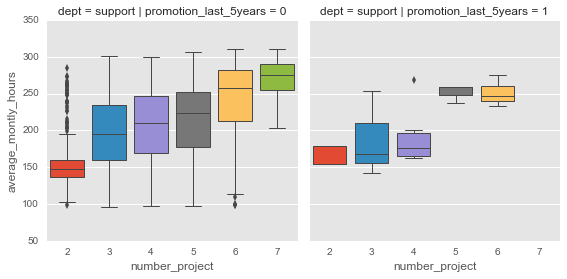

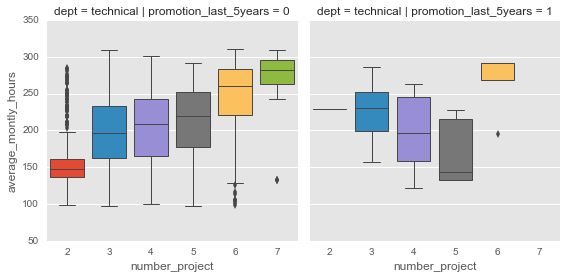

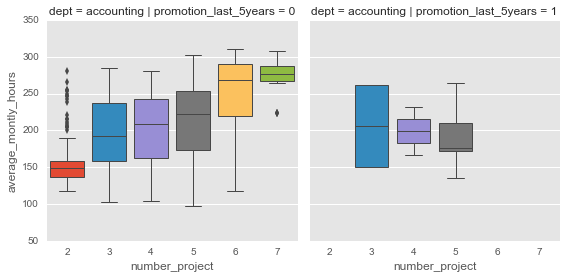

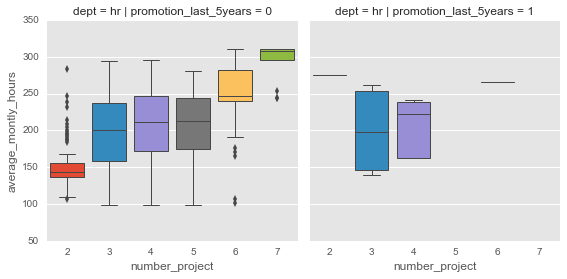

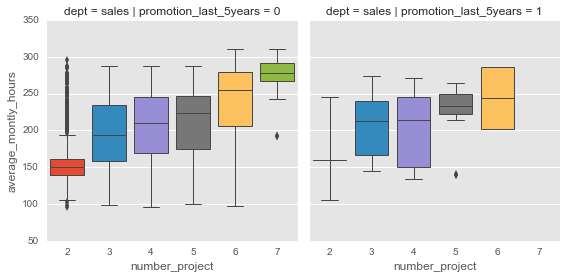

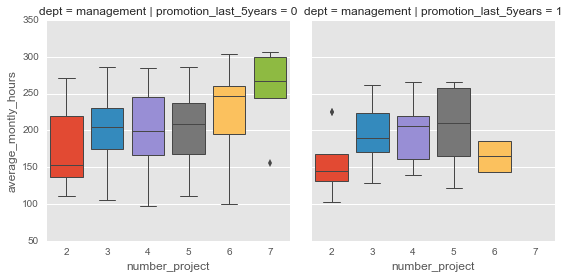

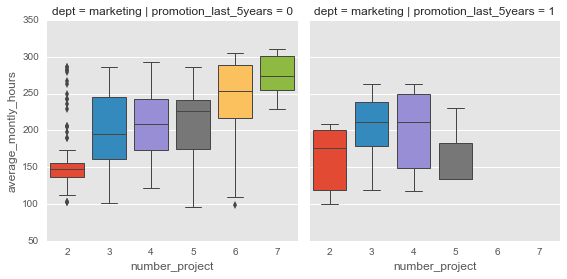

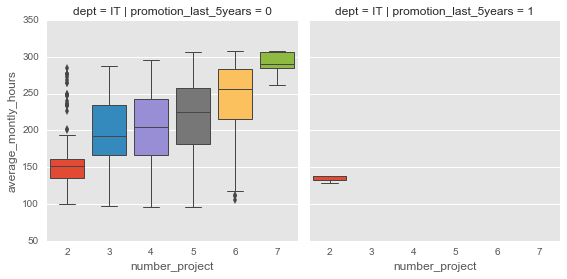

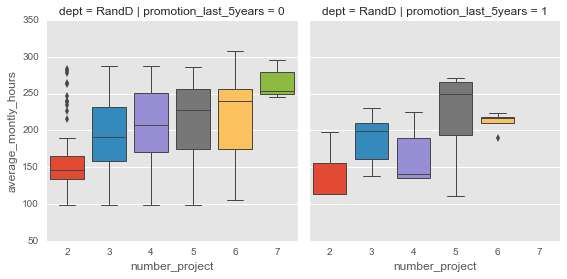

In [23]:
for i in set(data['dept']):
    aa= data[data['dept'].isin([i])]
    g = sns.factorplot(x='number_project', y="average_montly_hours",data=aa, 
                   saturation=1, kind="box", col = 'promotion_last_5years', row='dept', 
                   ci=None, aspect=1, linewidth=1) 

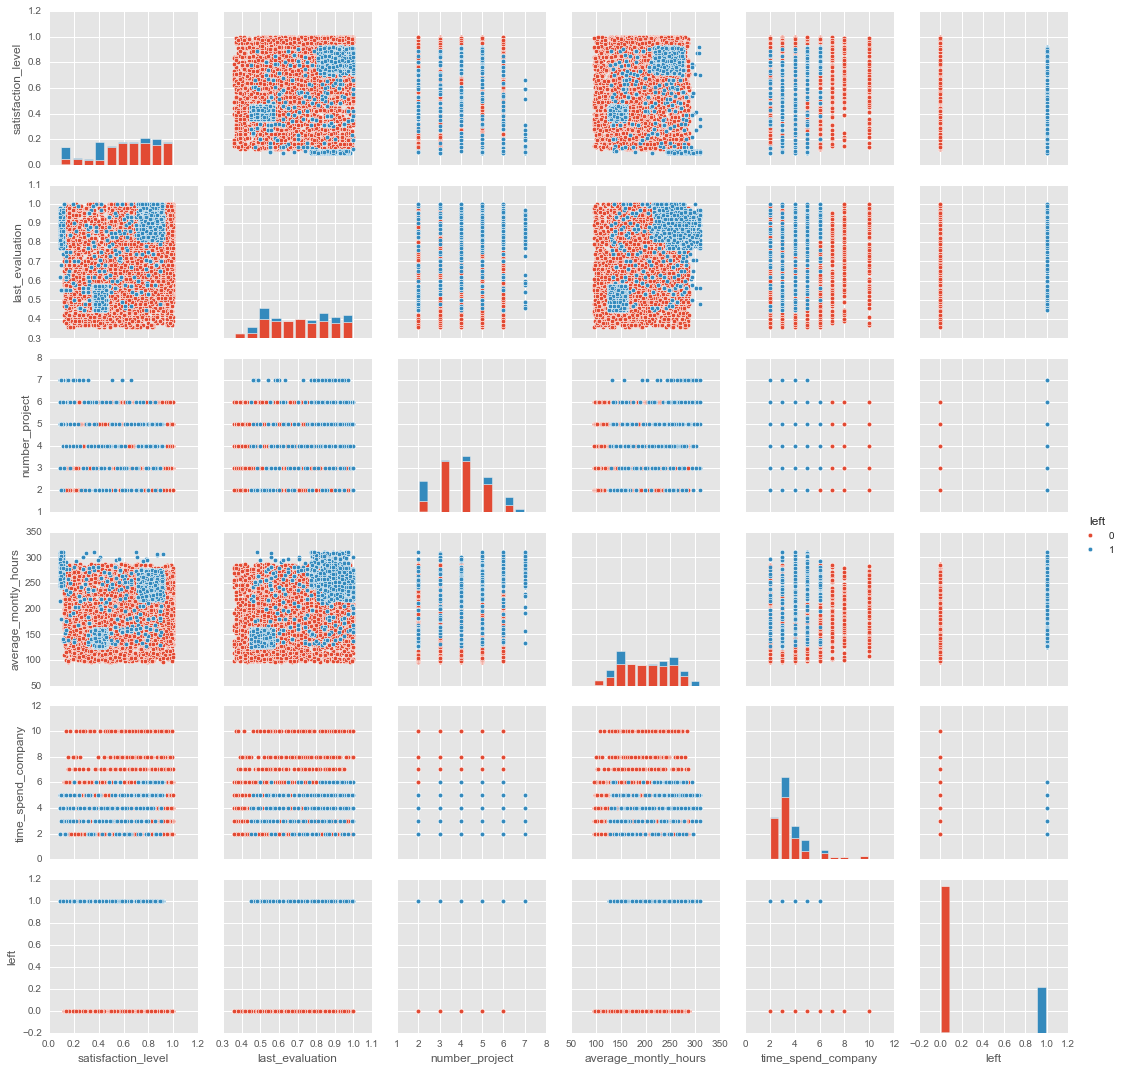

In [24]:
#on teste finalement d'autres graphiques en cherchant des informations qui auraient pu nous échapper
df_small = data[['satisfaction_level', 
                   'last_evaluation', 
                   'number_project',
                   'average_montly_hours', 
                   'time_spend_company','left']]
sns.pairplot(df_small, hue="left")

<p style="text-align:justify";>On retrouve les différents groupes qui sont partis notemment au niveau du nombre d'heures moyens et du niveau de satisfaction. Ainsi les individus quittant l'entreprises sont plutôt ceux qui font peu d'heure et ont un niveau de satisfaction bas ou ceux qui font beaucoup d'heure avec un niveau de satisfaction haut.
<p>&nbsp; </p>
On retrouve aussi que les employés avec un niveau de satisfaction bas ont un nombre d'heure travaillés très élevé, plus de 5 projets ce qui les fait passer plus d'heure au sein de l'entreprise que la normale. Bien que parfois la dernière évaluation peut être élevée les employés ne sont pas satisfaits.</p>

### Conclusion:

---
<p style="text-align:justify";>On peut donc séparer deux groupes d'employés selon leurs performances. Ceux performant un peu moins bien que la moyenne semble être surchargés par leur travail. Ils recoivent en général beaucoup de projets ou peut être des projets difficiles qui font qu'ils travaillent beaucoup et ont un niveau de satisfaction assez bas. De plus leur performance n'étant pas excellente ils ont pas ou très peu d'augmentation ou de promotion. Comme on a pu le voir le temps passé au sein de l'entreprise semble être un facteur déterminant, on peut supposer que le manque de reconnaissance dans leur travail ou d'augmentation qui les mènes à quitter l'entreprise.
<p>&nbsp; </p> 
Les employés avec de hautes performances ne semblent pas être surexploité au contraire. Il semblerait qu'ils partent juste parcequ'ils ne sont pas assez satisfait de leur travail, manque de challenge peut être. On peut penser qu'ils font des projets plus facile ce qui leur permet d'avoir une bonne performance cepandant ils ne resultent pas par une promotion ou une augmentation de salaire. Ce qui ne les satisfait pas.</p>

---

## Analyse en Composante Principale:
-----

On recode les variables 'dept' et 'salary' en numérique.

In [10]:
print(data.columns)

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'dept', 'salary'],
      dtype='object')


In [11]:
data.columns=['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'dept', 'salary']
data['departement_index'] = data['dept']

department_groups = {'sales': 1, 
                     'marketing': 2, 
                     'product_mng': 3, 
                     'technical': 4, 
                     'IT': 5, 
                     'RandD': 6, 
                     'accounting': 7, 
                     'hr': 8, 
                     'support': 8, 
                     'management': 9 
                    }
data['departement_index'] = data.dept.map(department_groups)
salary_groups = {'low': 0, 'medium': 1, 'high': 2}
data['salary_index']=data['salary']
data.salary_index = data.salary.map(salary_groups)


data.columns
data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,dept,salary,departement_index,salary_index
0,0.38,0.53,2,157,3,0,1,0,sales,low,1,0
1,0.80,0.86,5,262,6,0,1,0,sales,medium,1,1
2,0.11,0.88,7,272,4,0,1,0,sales,medium,1,1
3,0.72,0.87,5,223,5,0,1,0,sales,low,1,0
4,0.37,0.52,2,159,3,0,1,0,sales,low,1,0


On supprimes les colonnes en caractères pour faire une ACP

In [12]:
df=data
df = df.drop('dept', 1)
df = df.drop('salary', 1)

df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,departement_index,salary_index
0,0.38,0.53,2,157,3,0,1,0,1,0
1,0.80,0.86,5,262,6,0,1,0,1,1
2,0.11,0.88,7,272,4,0,1,0,1,1
3,0.72,0.87,5,223,5,0,1,0,1,0
4,0.37,0.52,2,159,3,0,1,0,1,0


In [13]:
from sklearn.decomposition import PCA

In [14]:
pca = PCA()
print(pca.fit(df))
pca.explained_variance_ratio_

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)


array([  9.95293173e-01,   3.04366521e-03,   8.67996984e-04,
         4.72613735e-04,   1.64699171e-04,   7.49722715e-05,
         4.61215153e-05,   1.94687551e-05,   9.15248445e-06,
         8.13670892e-06])

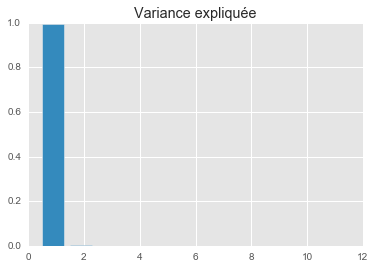

In [15]:
plt.bar(np.arange(len(pca.explained_variance_ratio_))+0.5, pca.explained_variance_ratio_)
plt.title("Variance expliquée")

Toute la variance expliqué est sur le premier axe. On reéchelle les données afin d'avoir des résultats plus probants.

In [16]:
from sklearn.preprocessing import StandardScaler
X = df.iloc[:,1:10]
scaler = StandardScaler()
X=scaler.fit_transform(X)
X

array([[-1.08727529, -1.46286291, -0.88203988, ..., -0.14741182,
        -1.20913252, -0.93336794],
       [ 0.84070693,  0.97111292,  1.22042276, ..., -0.14741182,
        -1.20913252,  0.63609235],
       [ 0.95755433,  2.59376348,  1.4206573 , ..., -0.14741182,
        -1.20913252,  0.63609235],
       ..., 
       [-1.08727529, -1.46286291, -1.16236823, ..., -0.14741182,
         1.32566872, -0.93336794],
       [ 1.42494396,  1.7824382 ,  1.58084493, ..., -0.14741182,
         1.32566872, -0.93336794],
       [-1.14569899, -1.46286291, -0.86201642, ..., -0.14741182,
         1.32566872, -0.93336794]])

In [17]:
pca.fit_transform(X)

array([[ -1.72809676e+00,  -2.24186745e+00,   3.79178926e-01, ...,
         -6.60187441e-01,  -3.58501221e-01,  -1.27491750e-01],
       [  2.41115304e+00,  -1.02747502e+00,   1.09075476e+00, ...,
         -6.74619210e-01,  -3.12785838e-01,  -6.26149543e-02],
       [  3.06076541e+00,  -8.63794530e-01,   1.74286511e-01, ...,
         -1.32158931e+00,   2.17885491e-01,   1.23046792e+00],
       ..., 
       [ -1.83845414e+00,  -1.80634741e+00,   1.10129288e+00, ...,
         -4.43107037e-01,  -2.88845706e-01,   9.13130593e-05],
       [  2.99708746e+00,  -1.26215637e+00,   2.93560494e-01, ...,
         -5.75115604e-01,  -3.63563730e-02,   3.75234781e-01],
       [ -1.70356778e+00,  -1.80139473e+00,   1.07047790e+00, ...,
         -5.71250373e-01,  -1.51233580e-01,  -1.94387330e-01]])

In [18]:
explained_variance=pca.explained_variance_ratio_
explained_variance

array([ 0.20417976,  0.1419561 ,  0.12019654,  0.11162589,  0.10583806,
        0.09792649,  0.08116223,  0.07431244,  0.0628025 ])

In [38]:
print(sum(pca.explained_variance_ratio_[0:8]))
print(sum(pca.explained_variance_ratio_[0:7]))
print(sum(pca.explained_variance_ratio_[0:6]))
print(sum(pca.explained_variance_ratio_[0:5]))
print(sum(pca.explained_variance_ratio_[0:4]))
print(sum(pca.explained_variance_ratio_[0:3]))
print(sum(pca.explained_variance_ratio_[0:2]))
print(sum(pca.explained_variance_ratio_[0:1]))

0.937197500885
0.862885062925
0.781722836656
0.683796345587
0.577958286539
0.466332393316
0.346135857038
0.204179755162


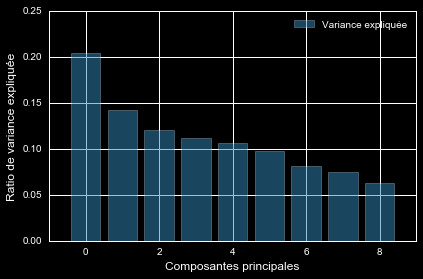

In [19]:
with plt.style.context('dark_background'):
    plt.figure(figsize=(6, 4))

    plt.bar(range(9), explained_variance, alpha=0.5, align='center', label='Variance expliquée')
    plt.ylabel('Ratio de variance expliquée')
    plt.xlabel('Composantes principales')
    plt.legend(loc='best')
    plt.tight_layout()

Reduced dataset shape: (14999, 6)


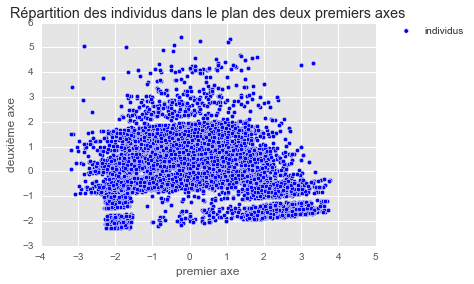

In [47]:
pca = PCA(n_components=6)
X_reduced = pca.fit_transform(X)
print("Reduced dataset shape:", X_reduced.shape)

import pylab as pl
pl.title('Répartition des individus dans le plan des deux premiers axes')
pl.xlabel("premier axe")
pl.ylabel("deuxième axe")
pl.scatter(X_reduced[:, 0], X_reduced[:, 1],
           cmap='RdYlBu', label='individus')
pl.legend()
pl.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [46]:
x1 = X_reduced[:,0]
y1 = X_reduced[:,1]


# Create a trace
trace = go.Scatter(
    x = x1,
    y = y1,
    name = 'Individus',
    mode = 'markers'
)

#Titre
layout = dict(title = 'Répartition des individus dans le plan des deux premiers axes',
              yaxis = dict(
                    zeroline = False,
                    title = 'Deuxième axe',
            ),
              xaxis = dict(
                    zeroline = False,
                    title = 'Premier axe',
            ),
        )

dataviz = [trace]

fig = dict(data=dataviz, layout=layout)

# Plot and embed in ipython notebook!
plotly.offline.iplot(fig)

In [70]:
from sklearn.cluster import KMeans
k_means = KMeans(n_clusters=5)
k_means.fit(X)
y_pred = k_means.predict(X)
pl.title('groupés par leur distance les uns aux autres')

pl.xlabel("premier axe")
pl.ylabel("deuxième axe")
pl.margins(0)
pl.size=8
pl.suptitle('Répartition des individus dans le plan des deux premiers axes')
mpl_fig2 = pl.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_pred,
           cmap='RdYlBu')


fig2 = mpl_fig2.get_figure()
plotly.offline.iplot(tls.mpl_to_plotly(fig2))

#attention un groupe est en blanc cassé il peut être dur a voir

## Prédiction
----

On cherche à atribuer un score à chaque classificateur qui sera une moyenne sur trois essais de calcul du score. Le tout afin de sélectioner le meilleur classificateur pour prédire la variable'left'.

In [27]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import cross_validation


mod_df = data #On va retransformer notre dataframe en introduisant des indicatrices pour les départements

classifiers = [('RandomForestClassifierG', RandomForestClassifier(n_jobs=-1, criterion='gini')),
               ('RandomForestClassifierE', RandomForestClassifier(n_jobs=-1, criterion='entropy')),
               ('AdaBoostClassifier', AdaBoostClassifier()),
               ('ExtraTreesClassifier', ExtraTreesClassifier(n_jobs=-1)),
               ('KNeighborsClassifier', KNeighborsClassifier(n_jobs=-1)),
               ('DecisionTreeClassifier', DecisionTreeClassifier()),
               ('ExtraTreeClassifier', ExtraTreeClassifier()),
               ('LogisticRegression', LogisticRegression()),
               ('GaussianNB', GaussianNB()),
               ('BernoulliNB', BernoulliNB())
              ]
allscores = []



salary_groups = {'low': 0, 'medium': 1, 'high': 2}

department_groups = {'sales': 1, 
                     'marketing': 2, 
                     'product_mng': 3, 
                     'technical': 4, 
                     'IT': 5, 
                     'RandD': 6, 
                     'accounting': 7, 
                     'hr': 8, 
                     'support': 9, 
                     'management': 10 
                    }
mod_df.salary = mod_df.salary.map(salary_groups)

mod_df['deptgrps'] = mod_df.dept.map(department_groups)

for dept in mod_df.dept.unique():
    mod_df['dept_'+dept] = (mod_df.dept == dept).astype(int)
mod_df = mod_df.drop('dept', axis=1)
mod_df = mod_df.drop('departement_index', axis=1)
mod_df = mod_df.drop('salary_index', axis=1)

x, Y = mod_df.drop('left', axis=1), mod_df['left']
for name, classifier in classifiers:
    scores = []
    for i in range(3): # on fait la moyenne sur trois essais on pourrait faire plus mais c'est long...
        roc = cross_validation.cross_val_score(classifier, x, Y, scoring='roc_auc', cv=20)
        scores.extend(list(roc))
    scores = np.array(scores)
    print(name, scores.mean())
    new_data = [(name, score) for score in scores]
    allscores.extend(new_data)

c:\users\utilisateur\anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


RandomForestClassifierG 0.991164129643
RandomForestClassifierE 0.991268179806
AdaBoostClassifier 0.982421051336
ExtraTreesClassifier 0.990483096699
KNeighborsClassifier 0.970264052585
DecisionTreeClassifier 0.978863821965
ExtraTreeClassifier 0.962966367652
LogisticRegression 0.815324824455
GaussianNB 0.814934951501
BernoulliNB 0.640773699636


[None, None, None, None, None, None, None, None, None, None]

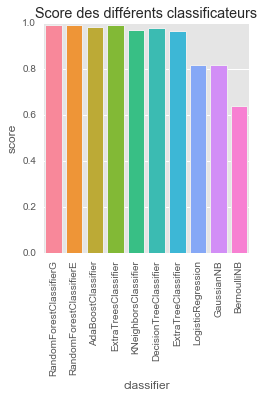

In [28]:
temp = pd.DataFrame(allscores, columns=['classifier', 'score'])
sns.factorplot(x='classifier', 
               y="score",data=temp, 
               saturation=1, 
               kind="bar", 
               ci=None, 
               aspect=1, 
               linewidth=1) 
locs, labels = plt.xticks()
plt.title('Score des différents classificateurs')
plt.setp(labels, rotation=90)

[None, None, None, None, None, None, None, None, None, None]

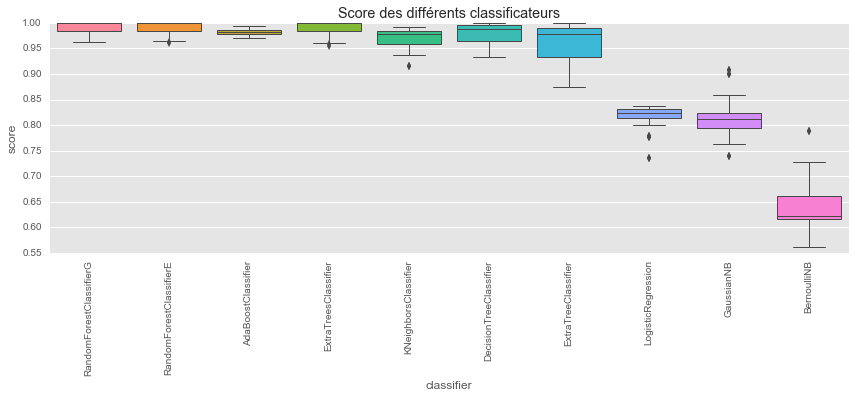

In [29]:
temp = pd.DataFrame(allscores, columns=['classifier', 'score'])
#sns.violinplot('classifier', 'score', data=temp, inner=None, linewidth=0.3)
sns.factorplot(x='classifier', y="score",data=temp, 
               saturation=1, kind="box", 
               ci=None, aspect=3, linewidth=1)  
plt.title('Score des différents classificateurs')
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)

On choisi de faire une Random Forest car c'est celui qui a le plus haut score et semble le plus adapté d'autant plus que lorsqu'une personne choisi de quitter son emploi c'est à la suite d'une série de décisions que la random forest peut petu-être assimiler.

In [33]:
clf = RandomForestClassifier()

In [118]:
from sklearn.model_selection import train_test_split
xtrain, xtest, Ytrain, Ytest = train_test_split(x, Y, test_size = 0.4)

In [119]:
clf.fit(xtrain, Ytrain)
y_val_l = clf.predict_proba(xtest)
print("Validation accuracy: ", sum(pd.DataFrame(y_val_l).idxmax(axis=1).values
                                   == Ytest)/len(Ytest))

Validation accuracy:  0.985666666667


La précision semble excellente.

In [120]:
indices = np.argsort(clf.feature_importances_)[::-1]

# On regarde le classement des charactéristiques
print('Classement des caractéristiques:')

for f in range(x.shape[1]):
    print('%d. caractéristique %d %s (%f)' % (f+1 , indices[f], x.columns[indices[f]],
                                      clf.feature_importances_[indices[f]]))

Classement des caractéristiques:
1. caractéristique 0 satisfaction_level (0.250865)
2. caractéristique 2 number_project (0.199380)
3. caractéristique 3 average_montly_hours (0.182953)
4. caractéristique 4 time_spend_company (0.178927)
5. caractéristique 1 last_evaluation (0.140136)
6. caractéristique 7 salary (0.011936)
7. caractéristique 5 Work_accident (0.011861)
8. caractéristique 8 deptgrps (0.005904)
9. caractéristique 6 promotion_last_5years (0.003048)
10. caractéristique 12 dept_technical (0.002886)
11. caractéristique 9 dept_sales (0.002373)
12. caractéristique 13 dept_support (0.002008)
13. caractéristique 18 dept_RandD (0.001761)
14. caractéristique 15 dept_IT (0.001708)
15. caractéristique 16 dept_product_mng (0.001101)
16. caractéristique 17 dept_marketing (0.000969)
17. caractéristique 14 dept_management (0.000805)
18. caractéristique 10 dept_accounting (0.000743)
19. caractéristique 11 dept_hr (0.000637)


<p style="text-align:justify";>On peut alors observer les facteurs qui poussent les employés à quitter leur emploi parmis les variables misent à disposition. Ainsi ils partent d'abord car ils ne sont pas satisfait par leur travail, puis à cause du temps qu'ils passent dans l'entreprise, de leur nombre de projets et des heures mensuelles travaillées. Le salaire a aussi un impact assez prévisible. Enfin cela peut être lié à un accident du travail.</p>

On retrouve des conclusions similaires à celles obtenues grâce aux statistiques descriptives.

### Prédiction des employés qui risquent de partir bientôt:

In [121]:
stay = mod_df[mod_df['left'] == 0]
stay_copy = pd.get_dummies(stay)

In [122]:
print(stay_copy.shape)
stay_copy.head()

(11428, 20)


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary,deptgrps,dept_sales,dept_accounting,dept_hr,dept_technical,dept_support,dept_management,dept_IT,dept_product_mng,dept_marketing,dept_RandD
2000,0.58,0.74,4,215,3,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0
2001,0.82,0.67,2,202,3,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0
2002,0.45,0.69,5,193,3,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0
2003,0.78,0.82,5,247,3,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0
2004,0.49,0.60,3,214,2,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0


In [123]:
df1 = stay_copy
y = df1['left'].values
df1 = df1.drop(['left'],axis=1)
X = df1.values

In [124]:
pred = clf.predict_proba(X)

#on donne à chacun une probabilité de quitter l'entreprise

In [125]:
sum(pred[:,1]==1)

2

In [126]:
print(stay[pred[:,1]>=0.5].shape)
stay[pred[:,1]>=0.5]

(22, 20)


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary,deptgrps,dept_sales,dept_accounting,dept_hr,dept_technical,dept_support,dept_management,dept_IT,dept_product_mng,dept_marketing,dept_RandD
2095,0.54,0.67,4,282,6,0,0,0,1,4,0,0,0,1,0,0,0,0,0,0
2703,0.76,0.93,3,271,5,0,0,0,0,8,0,0,1,0,0,0,0,0,0,0
2727,0.15,0.56,6,140,5,0,0,0,1,9,0,0,0,0,1,0,0,0,0,0
4769,0.13,0.95,5,149,2,0,0,0,0,4,0,0,0,1,0,0,0,0,0,0
5305,0.26,0.51,2,284,2,0,0,0,0,4,0,0,0,1,0,0,0,0,0,0
5773,0.45,0.62,6,129,5,0,0,0,0,9,0,0,0,0,1,0,0,0,0,0
5994,0.80,0.99,4,255,5,1,0,0,0,4,0,0,0,1,0,0,0,0,0,0
6028,0.21,0.94,3,287,5,0,0,0,2,6,0,0,0,0,0,0,0,0,0,1
6263,0.90,0.87,4,231,5,0,0,0,0,10,0,0,0,0,0,1,0,0,0,0
6448,0.32,0.50,2,143,3,0,0,0,2,4,0,0,0,1,0,0,0,0,0,0


Il semblerait que peu d'employés vont partir pour sûr, ici 2 mais cela peut varier en fonction de la taille de l'échantillon de test. On peut regarder les employés ayant une probabilité de plus de 50% de partir comme ci-dessus.

<p style="text-align:justify";>Le modèle semble avoir de bonne performance et être exploitable. Il permet de mettre en valeur les employés en 'danger'. L'entreprise pourrait alors prendre des décisions adéquates comme leur attribuer une augmentation ou une promotion afin de les valoriser et leur permettre de rester.
<p>&nbsp; </p>
Le modèle peut aussi être appliqué à des jeux plus importants. Il semble aussi que la collecte des données pour l'entreprise ne soit pas excessivement couteuse. On peut cependant peut être remettre en cause la satisfaction qui est subjective.
<p>&nbsp; </p>
Si le modèle se trompe, l'entreprise agira afin d'augmenter la satisfaction d'un employé non susceptible de quitter son travail ce qui n'est pas très grave non plus.</p>